In [40]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
# Afficher toutes les lignes du résultat
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
def maximimsation_marge(montant,status):
    taux_marge = 0.05
    if status == "TP":
        res = 0 # le fraudeur est détecté
    elif status == "TN":
        res = taux_marge * montant # un client honnête est accepté
    elif status == "FP":
        res = 0.7*taux_marge * montant # un client honnête est bloqué     
    elif status == "FN": # un fraudeur est accepté 
        if montant <= 20:
            res = 0
        elif montant <= 50:
            res = -0.2 * montant
        elif montant <= 100:
            res = -0.3 * montant
        elif montant <= 200:
            res = -0.5 * montant
        else:
            res = -0.8 * montant
    return res

In [17]:
def application_regles(y_test,y_pred):
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'status': "null"})
    for index, row in df.iterrows():
        if row['y_test'] == 1 and row['y_pred'] == 1:
            df.at[index, 'status'] = "TP"
        elif row['y_test'] == 0 and row['y_pred'] == 0:
            df.at[index, 'status'] = "TN"
        elif row['y_test'] == 0 and row['y_pred'] == 1:
            df.at[index, 'status'] = "FP"
        elif row['y_test'] == 1 and row['y_pred'] == 0:
            df.at[index, 'status'] = "FN"
    return df

In [43]:
methods = ["undersampling","smote"]

method = "smote"


df_train = pd.read_csv("../data/"+method+"/dataframe_train_50_percent.csv")
print(df_train.shape)


df_test = pd.read_csv("../data/"+method+"/dataframe_test.csv")
print(df_test.shape)

(5232519, 22)
(747411, 22)


In [44]:
df_train.head()

,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Jour,Mois,FlagImpaye
0,20.00,1,0,0,0,551.0,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134,1,2,0
1,20.00,1,0,0,0,551.0,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817,1,2,0
2,57.64,1,0,0,0,549.0,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058,1,2,0
3,54.29,0,1,1,1,267.0,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128,1,2,0
4,26.90,1,0,0,0,549.0,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607,1,2,0


In [20]:
col_to_drop = ["CodeDecision"]

df_train = df_train.drop(columns=col_to_drop)
df_test = df_test.drop(columns=col_to_drop)

df_train = df_train.sample(n=1000, random_state=42)
df_test = df_test.sample(n=3, random_state=42)

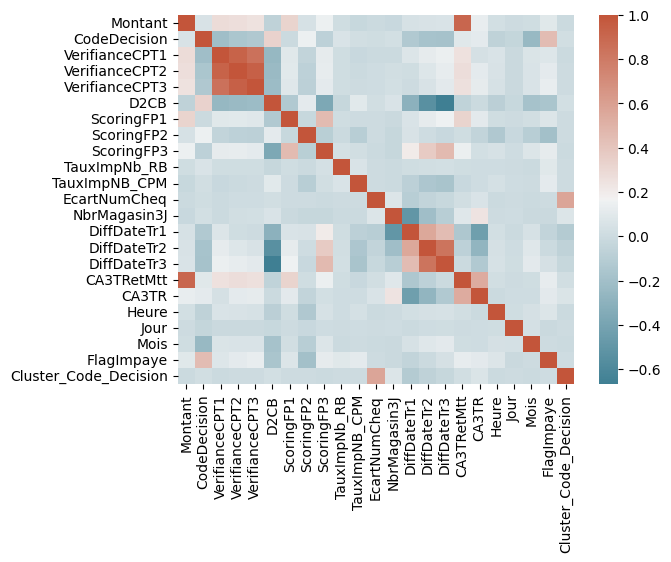

In [32]:
corr = df_train.corr()
plot = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 20, as_cmap=True))

# STANDARDISATION

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

print(df_train.dtypes)
def standardize_dataframe(dataframe):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = dataframe.select_dtypes(include=['float64', 'int64','int32']).columns
    
    # Copier le DataFrame pour éviter de modifier l'original
    standardized_df = dataframe.copy()
    
    # Standardiser les colonnes numériques
    scaler = StandardScaler()
    standardized_df[numeric_cols] = scaler.fit_transform(dataframe[numeric_cols])
    
    return standardized_df

Montant           float64
CodeDecision        int64
VerifianceCPT1      int64
VerifianceCPT2      int64
VerifianceCPT3      int64
D2CB              float64
ScoringFP1        float64
ScoringFP2        float64
ScoringFP3        float64
TauxImpNb_RB      float64
TauxImpNB_CPM     float64
EcartNumCheq        int64
NbrMagasin3J        int64
DiffDateTr1       float64
DiffDateTr2       float64
DiffDateTr3       float64
CA3TRetMtt        float64
CA3TR             float64
Heure               int64
Jour                int64
Mois                int64
FlagImpaye          int64
dtype: object


# INITIALISATION - SCORER

In [47]:
def scorer_marge(y_true, y_pred, X_train):
    df_res = application_regles(y_true, y_pred)
    total_marge = 0
    
    for row in df_res.itertuples():
        montant = X_train.at[row.Index, 'Montant']  # Accéder au montant pour chaque ligne
        total_marge += maximimsation_marge(montant, row.status)
    
    return total_marge

# INITIALISATION - CLASSIFIERS

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Machine learning algorithms like linear regression, logistic regression, neural network, PCA (principal component analysis), etc., 
#that use gradient descent as an optimization technique require data to be scaled

class_weights = {0: 1.0, 1: 10.0}  

models = {
    'Random_Forest': RandomForestClassifier(criterion="gini"),
    'xgb_model': xgb.XGBClassifier(objective='binary:logistic'),
    'Gradient_Boosting': GradientBoostingClassifier(),
    #'K_Nearest_Neighbors': KNeighborsClassifier(),
    'Support_Vector_Machine': SVC(),
    #'Neural_Network': MLPClassifier(),
    #'Linear_Discriminant_Analysis': LinearDiscriminantAnalysis(),
    'Logistic_Regression': LogisticRegression()
}

print(models)
methods = ["smote","undersampling"]

{'Random_Forest': RandomForestClassifier(), 'xgb_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'Gradient_Boosting': GradientBoostingClassifier(), 'Support_Vector_Machine': SVC(), 'Logistic_Regression': LogisticRegression()}


# TRAINNING : GRID SEARCH - OPTIMISATION MARGE

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.model_selection import TimeSeriesSplit
import pickle

print(models)


# Classifiers (UnderSampling):
# Logistic Regression classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
# GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.
# Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.


for m in methods:
    df_train = pd.read_csv("../data/"+m+"/dataframe_train_50_percent.csv")
    #df_train = df_train.sample(n=1000, random_state=42)# test

    X_train = standardize_dataframe(X_train) # on standardise les données
    
    X_train = df_train.drop(columns=["FlagImpaye","CodeDecision"])
    y_train = df_train["FlagImpaye"]

    # Boucle sur chaque modèle
    for model_name, model in models.items():
        print(f"\nTraining {model_name} for method {m}...")

        # Définir le classificateur
        clf = model

        # Définir les paramètres que vous souhaitez tester dans la recherche de grille
        param_grid = {}

        # Ajouter des paramètres spécifiques pour chaque modèle
        if model_name == 'Random_Forest':
            param_grid = {
                          #'n_estimators': [3, 5, 10, 50, 100],
                          #'max_depth': [None, 10, 20],
                          #'min_samples_leaf': [10, 15, 20, 25, 40],
                          #'class_weight' : [None, class_weights],
                          'random_state': [42]
                          }
        elif model_name == 'xgb_model':
            param_grid = {
                #'n_estimators': [50, 100, 200],
                #'learning_rate': [0.01, 0.1, 0.2],
                #'max_depth': [3, 5, 7],
                #'subsample': [0.8, 1.0],
                #'colsample_bytree': [0.8, 1.0],
                #'gamma': [0, 0.1, 0.2],
                #'min_child_weight': [1, 5, 10],
                'random_state': [42]
            }
        elif model_name == 'Gradient_Boosting':
            param_grid = {
                #'n_estimators': [50, 100, 200],
                #'learning_rate': [0.01, 0.1, 0.2],
                #'max_depth': [3, 5, 7],
                #'subsample': [0.8, 1.0],
                #'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [1, 2, 4],
                #'max_features': [None, 'sqrt', 'log2'],
                'random_state': [42]
            }
        elif model_name == 'K_Nearest_Neighbors':
            param_grid = {
                #'n_neighbors': [3, 5, 7, 10],
                #'weights': ['uniform', 'distance'],
                #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                #'leaf_size': [20, 30, 40],
                #'p': [1, 2]
            }
        elif model_name == 'Support_Vector_Machine':
            param_grid = {
                #'C': [0.1, 1, 10],
                #'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                #'degree': [2, 3, 4],
                #'gamma': ['scale', 'auto'],
                #'class_weight': [None, 'balanced',class_weights],
                'random_state': [42]
                
            }
        elif model_name == 'Neural_Network':
            param_grid = {
                #'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                #'activation': ['relu', 'tanh', 'logistic'],
                #'solver': ['sgd', 'adam'],
                #'alpha': [0.0001, 0.001, 0.01],
                #'learning_rate': ['constant', 'invscaling', 'adaptive'],
                #'max_iter': [100, 200, 300],
                #'early_stopping': [True, False],
                'random_state': [42]
            }
        elif model_name == 'Linear_Discriminant_Analysis':
            param_grid = {
            #'solver': ['svd', 'lsqr', 'eigen'],
            #'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],
            #'n_components': [None, 1, 2, 3]
        }
        elif model_name == 'Logistic_Regression':
            param_grid = {
            #'penalty': ['l1', 'l2'],
            #'C': [0.001, 0.01, 0.1, 1, 10, 100],
            #'fit_intercept': [True, False],
            #'class_weight': [None, 'balanced'],
            #'solver': ['liblinear', 'saga'],
            #'max_iter': [100, 200, 300],
            'class_weight' : [None, class_weights],
            'random_state': [42]
        }
        

        scorer = make_scorer(scorer_marge,X_train=X_train,greater_is_better = True)

        # Utiliser TimeSeriesSplit pour la validation croisée
        tscv = TimeSeriesSplit(n_splits=4)

        # Créer la grille de recherche avec votre fonction personnalisée comme mesure d'évaluation
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=tscv, n_jobs=-1)

        # Effectuer la recherche de grille
        grid_search.fit(X_train, y_train)

        # Afficher les résultats
        print(f"\n Best parameters for {model_name}: ", grid_search.best_params_)
        print(f"Meilleure marge pour {model_name}: ", grid_search.best_score_)

        # Sauvegarder le meilleur modèle si nécessaire
        best_model = grid_search.best_estimator_
        filename = '../models/'+m+"/"+ model_name + '.pkl'
        pickle.dump(best_model, open(filename, "wb"))

# Prendre le meilleur modèle et tuner ses paramètres à fond !!!

{'Random_Forest': RandomForestClassifier(), 'xgb_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'Gradient_Boosting': GradientBoostingClassifier(), 'Support_Vector_Machine': SVC(), 'Logistic_Regression': LogisticRegression()}

Training Random_Forest for method smote...

 Best para

# LOAD MODELS

In [58]:
f1_df = pd.DataFrame(index=methods, columns=models.keys())
marge_df = pd.DataFrame(index=methods, columns=models.keys())

loaded_models = {}
for m in methods:
    loaded_models[m] = {}
    for model_name in models.keys():
        filename = '../models/'+m+"/"+ model_name + '.pkl'
        with open(filename, 'rb') as file:
            loaded_models[m][model_name] = pickle.load(file)

# PREDICTING LOADED MODELS

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

for m in methods:
    df_test = pd.read_csv("../data/"+m+"/dataframe_test.csv")
    #df_test = df_test.sample(n=15, random_state=42) # test

    X_test = standardize_dataframe(X_test) # on standardise les données

    X_test = df_test.drop(columns=["FlagImpaye","CodeDecision"])
    y_test = df_test["FlagImpaye"]

    for model_name, model in loaded_models.get(m, {}).items():
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_df.loc[m, model_name] = f1


        df_res = application_regles(y_test,y_pred)
        for row in df_res.itertuples():
            df_res.at[row.Index, 'marge'] = maximimsation_marge(X_test.at[row.Index, 'Montant'],row.status)

    
        total_marge = df_res['marge'].sum()
        marge_df.at[m  , model_name] = total_marge

        print("\n F1 score de ",model_name," sur l'ensemble de test :", f1)
        print(" Marge de ",model_name," sur l'ensemble de test :", total_marge)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)

        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[True, False])
        disp.plot()
        plt.show()



    
    # Ajouter la marge parfaite au fichier de résultats 
    df_res = application_regles(y_test,y_test)
    for row in df_res.itertuples():
        df_res.at[row.Index, 'marge'] = maximimsation_marge(X_test.at[row.Index, 'Montant'],row.status)

    total_marge = df_res['marge'].sum()
    marge_df.at[m ,"!_Modele_Parfait_!"] = total_marge
    print(" Marge du modèle PARFAIT sur l'ensemble de test :", total_marge)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Cluster_Code_Decision


# Marge 

In [ ]:
marge_df.to_csv('../data/marge.csv')
marge_df.head()

,Decision_Tree,Random_Forest,!_Modele_Parfait_!
smote,7166.2682,7845.4936,9259.8825
undersampling,6878.09415,6732.97475,9259.8825


# F1 Score

In [ ]:
f1_df.to_csv('../data/f1_score.csv')
f1_df.head()

,Decision_Tree,Random_Forest
smote,0.013136,0.021248
undersampling,0.021566,0.021053


In [ ]:
df_train["FlagImpaye"].value_counts()

FlagImpaye
0    772
1    228
Name: count, dtype: int64

In [ ]:
df_test["FlagImpaye"].value_counts()

FlagImpaye
0    2973
1      27
Name: count, dtype: int64

In [ ]:
# optimisation de la marge
#  donner la marge maximale (si modèle hypothétiquement parfait) et comparer avec la meilleure marge obtenue, du genre 'on a perdu 10% de marge par rapport au modèle parfait'

# faire ligne SMOTE 40% et 60% et comparer les résultats etc...
# faire ligne UNDERSAMPLING 40% et 60% et comparer les résultats etc....

# 1 => document
# 2 => clé valeur
# 3 => 
# 4 => graph 



# clé valeur , document, graph, colonne 